# Try to fit resonances using two different models

## Model 1

### $ S_{21}(\nu) = \frac{\sqrt{k_1 k_2}}{1 + k_1 + k_2 + iQ_0\delta} $
### $\delta = \frac{\nu - \nu_0}{\nu_0}$
### $l(\{x_i\},\theta) = -\frac{N}{2}\ln(2\pi) - N\ln(\sigma) - \frac{1}{2\sigma^{2}} \sum_{i=1}^{N} y_i - f(\{x_i\}|\vec{\theta})$

In [28]:
import dynesty
import numpy as np
import corner
import matplotlib.pyplot as plt
import plot_settings
from scipy.linalg import det
from numpy import log, sqrt

In [29]:
url = "https://raw.githubusercontent.com/biqute/QTLab2425/refs/heads/main/3Dqubit/data/empty_cavity_power_sweep/40mK_1.0kHz_-5dBm.csv"
data = np.loadtxt(url, delimiter=",", skiprows=1, usecols=(0, 1, 2), unpack=True)

In [30]:
F = data[0]
mag = np.abs(data[1] + 1j * data[2])

Center around maximum and scale frequencies

In [31]:
F = data[0][np.argmax(np.abs(data[1]))-100:np.argmax(np.abs(data[1]))+100]
S = data[1][np.argmax(np.abs(data[1]))-100:np.argmax(np.abs(data[1]))+100] + 1j * data[2][np.argmax(np.abs(data[1]))-100:np.argmax(np.abs(data[1]))+100]

In [32]:
F = (F - F[np.argmax(abs(S))])*1e-6
A = np.abs(S)

Aerr = np.ones_like(A) * 0.001
Ferr = np.ones_like(F) * 0.001

err = np.sqrt(Aerr**2 + Ferr**2)

sigma = np.sqrt(Aerr[0]**2 + Ferr[0]**2)

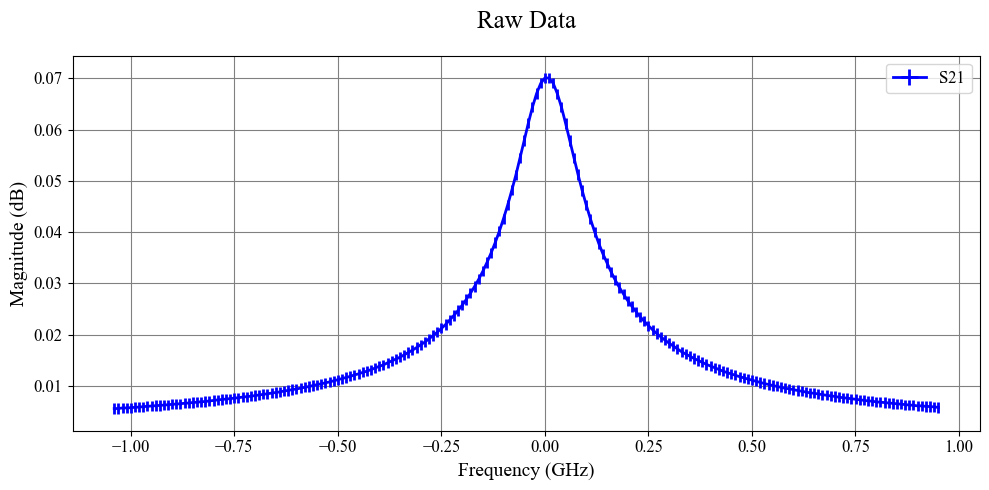

In [33]:
plt.errorbar(F, A, xerr=Ferr, yerr=Aerr, label="S21", color='blue', linewidth=2)
plt.title("Raw Data")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
plt.legend()

In [34]:
import scipy

def model(x):
    """Amplitude model"""
    k1, k2, Q0 = x
    
    if k1 < 0 or k2 < 0 or Q0 < 0:
        return np.nan
    numerator = sqrt(k1 * k2)
    denominator = np.sqrt((1 + k1 + k2)**2 + (Q0 * F)**2)
    return numerator / denominator

def prior_transform(u):
    
    # u[0]: defines min_k (log_k1), u[1]: offset to max_k (log_k2), u[2]: log_Q0
    log_k_min = np.log(1e-3)
    log_k_max = np.log(100)

    # Draw two values, enforce log_k1 ≤ log_k2 by sorting
    log_k1, log_k2 = np.sort([
        log_k_min + u[0] * (log_k_max - log_k_min),
        log_k_min + u[1] * (log_k_max - log_k_min)
    ])

    # Q0 log-uniform prior
    log_Q0 = np.log(1e1) + u[2] * (np.log(1e3) - np.log(1e1))

    return np.array([log_k1, log_k2, log_Q0])

def ptransform(u):
    """Transform to physical parameters"""
    x = np.zeros(3)
    x[0] = scipy.stats.halfnorm.ppf(u[0], loc=0, scale=1e-3)  # k1
    x[1] = scipy.stats.halfnorm.ppf(u[1], loc=0, scale=100)  # k2
    x[2] = scipy.stats.halfnorm.ppf(u[2], loc=0, scale=1e3)  # Q0
    
    return x


def log_likelihood(x):
    y_model = model(x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    chi2 = np.sum(((A - y_model) / err) ** 2)
    return -0.5 * chi2

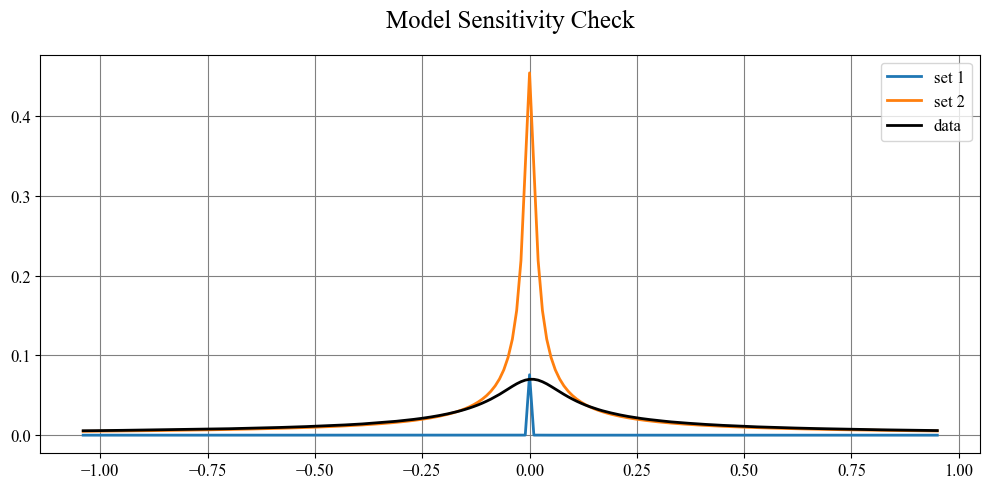

In [35]:
k1, k2, Q0 = 0.08, 0.1, 1e5
y1 = model([k1, k2, Q0])
k1b, k2b, Q0b = 5, 5, 1e3
y2 = model([k1b, k2b, Q0b])

import matplotlib.pyplot as plt
plt.plot(F, y1, label="set 1")
plt.plot(F, y2, label="set 2")
plt.plot(F, A, label="data", color='black', linewidth=2)
plt.legend(); plt.title("Model Sensitivity Check")
plt.show()


In [36]:
sampler = dynesty.DynamicNestedSampler(log_likelihood, ptransform, ndim=3, bound='multi', sample='auto')

In [37]:
sampler.run_nested(nlive_init=1000, nlive_batch=100, dlogz_init=1)

33818it [25:31, 22.08it/s, batch: 0 | bound: 555 | nc: 139 | ncall: 865855 | eff(%):  3.901 | loglstar:   -inf < -2669.349 <    inf | logz: -2707.011 +/-  0.192 | dlogz: 496.814 >  1.000] 


KeyboardInterrupt: 

In [16]:
sresults = sampler.results

In [17]:
from dynesty import utils as dyfunc


# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights


evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
labs = ['A', 'b', 'alpha', 't0']
print('Parameters:')
for m,c in zip(mean, np.sqrt(np.diag(cov))):
    print(f'{m:.3f} +/- {c:.3f}')

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(sresults)

Bayesian evidence 0.0
68% parameter credible regions are:
 [[0.05105674968551423, 0.05409554663138288], [0.05515952378270169, 0.05843857348659662], [6.904571797144756, 6.907445780280078]]

Parameters:
0.053 +/- 0.002
0.057 +/- 0.002
6.906 +/- 0.002


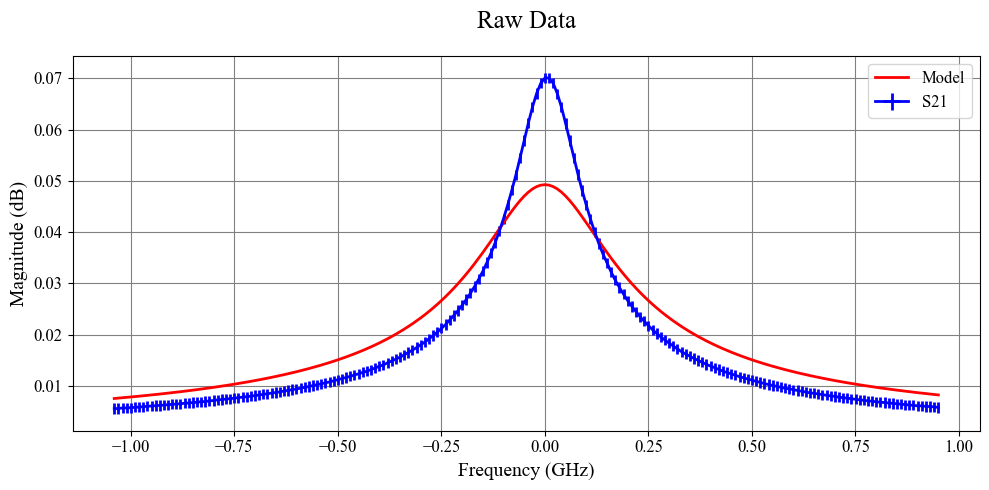

In [18]:
plt.errorbar(F, A, xerr=Ferr, yerr=Aerr, label="S21", color='blue', linewidth=2)
plt.plot(F, model(mean), label="Model", color='red', linewidth=2)
plt.title("Raw Data")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
plt.legend()

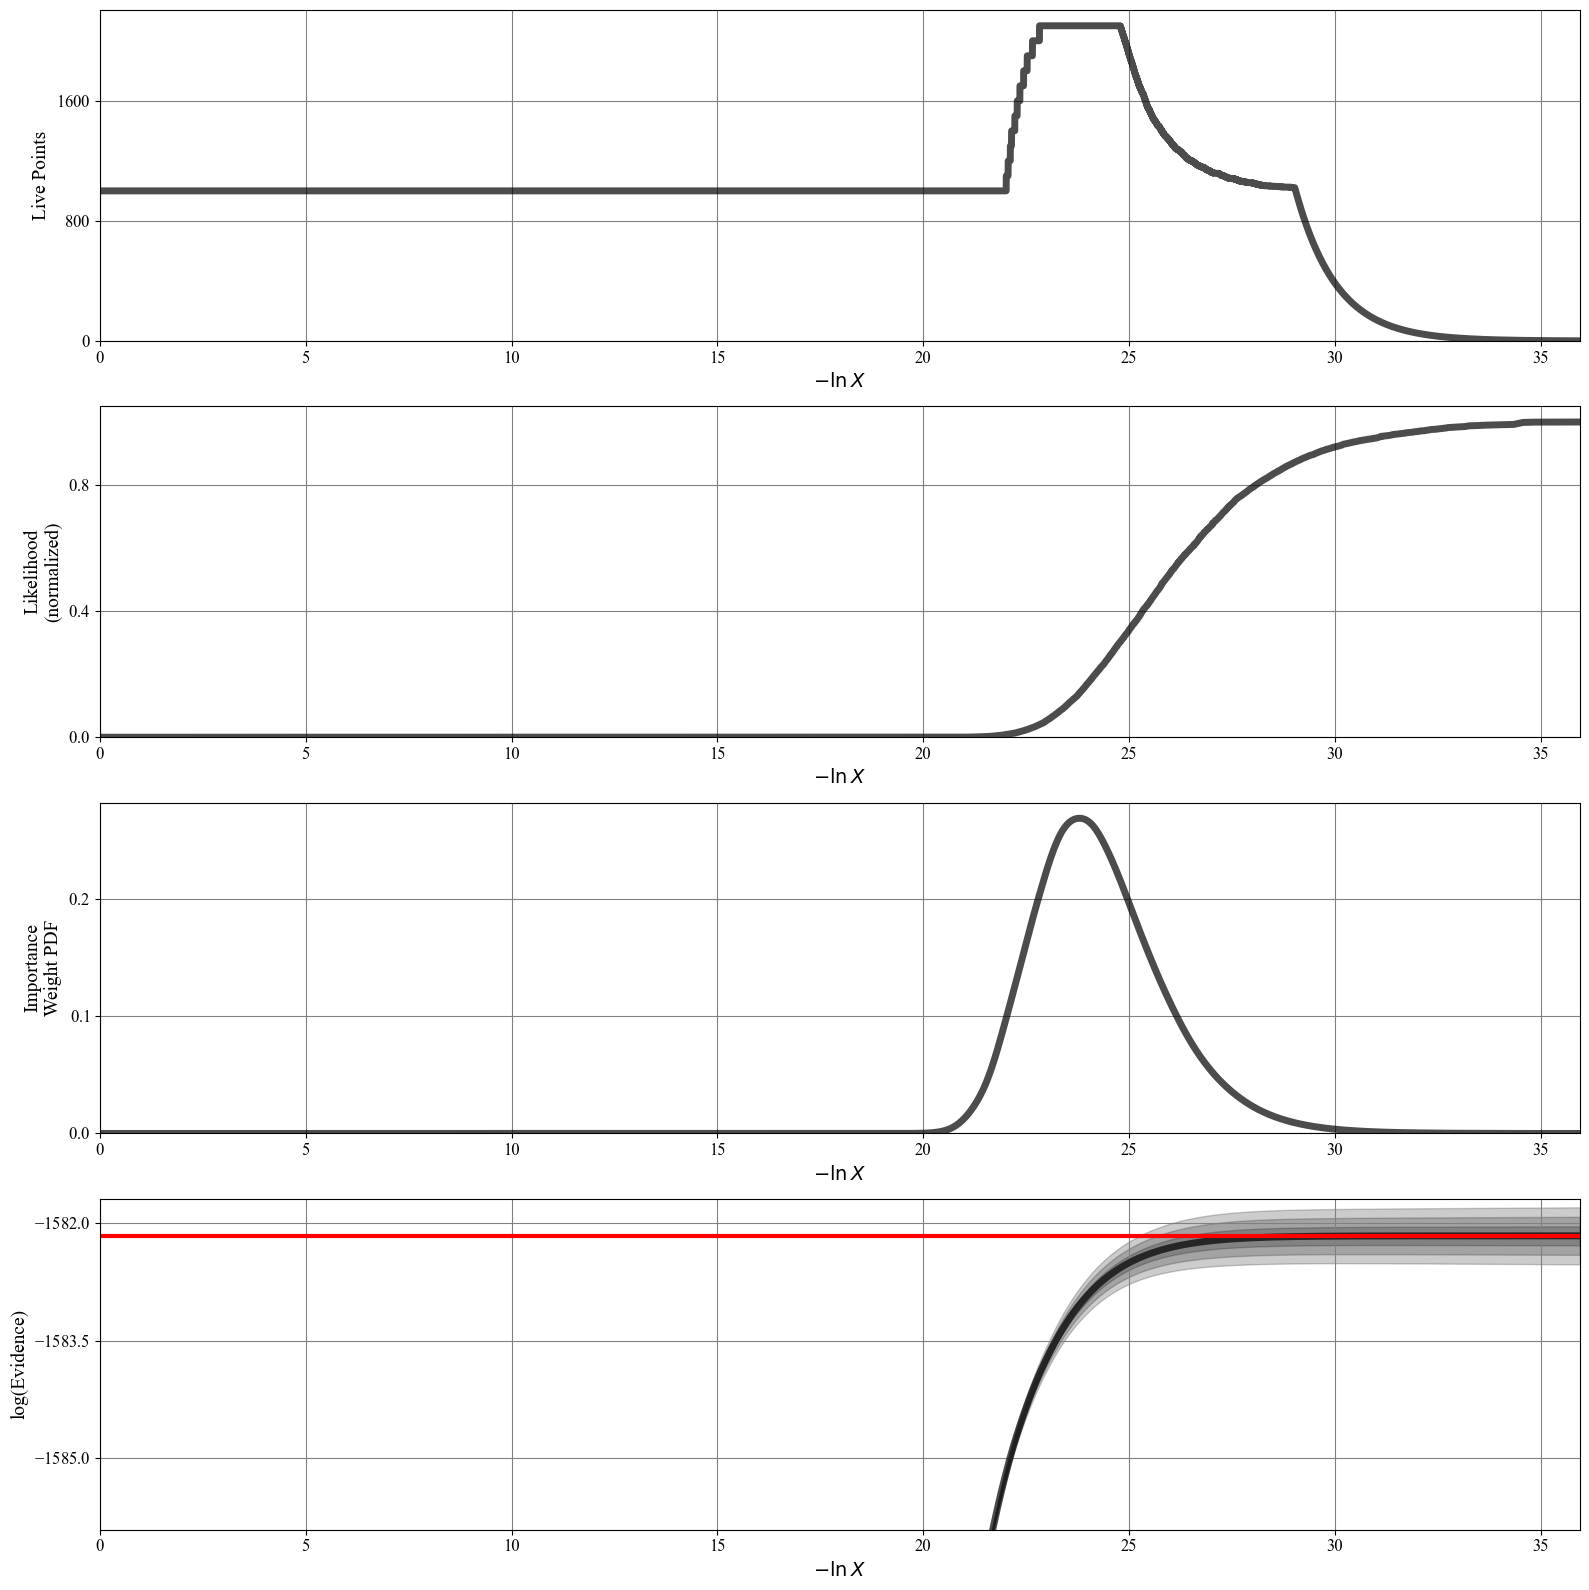

In [19]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults, logplot=True, color='black', lnz_truth=evidence, truth_color='red', use_math_text=True)

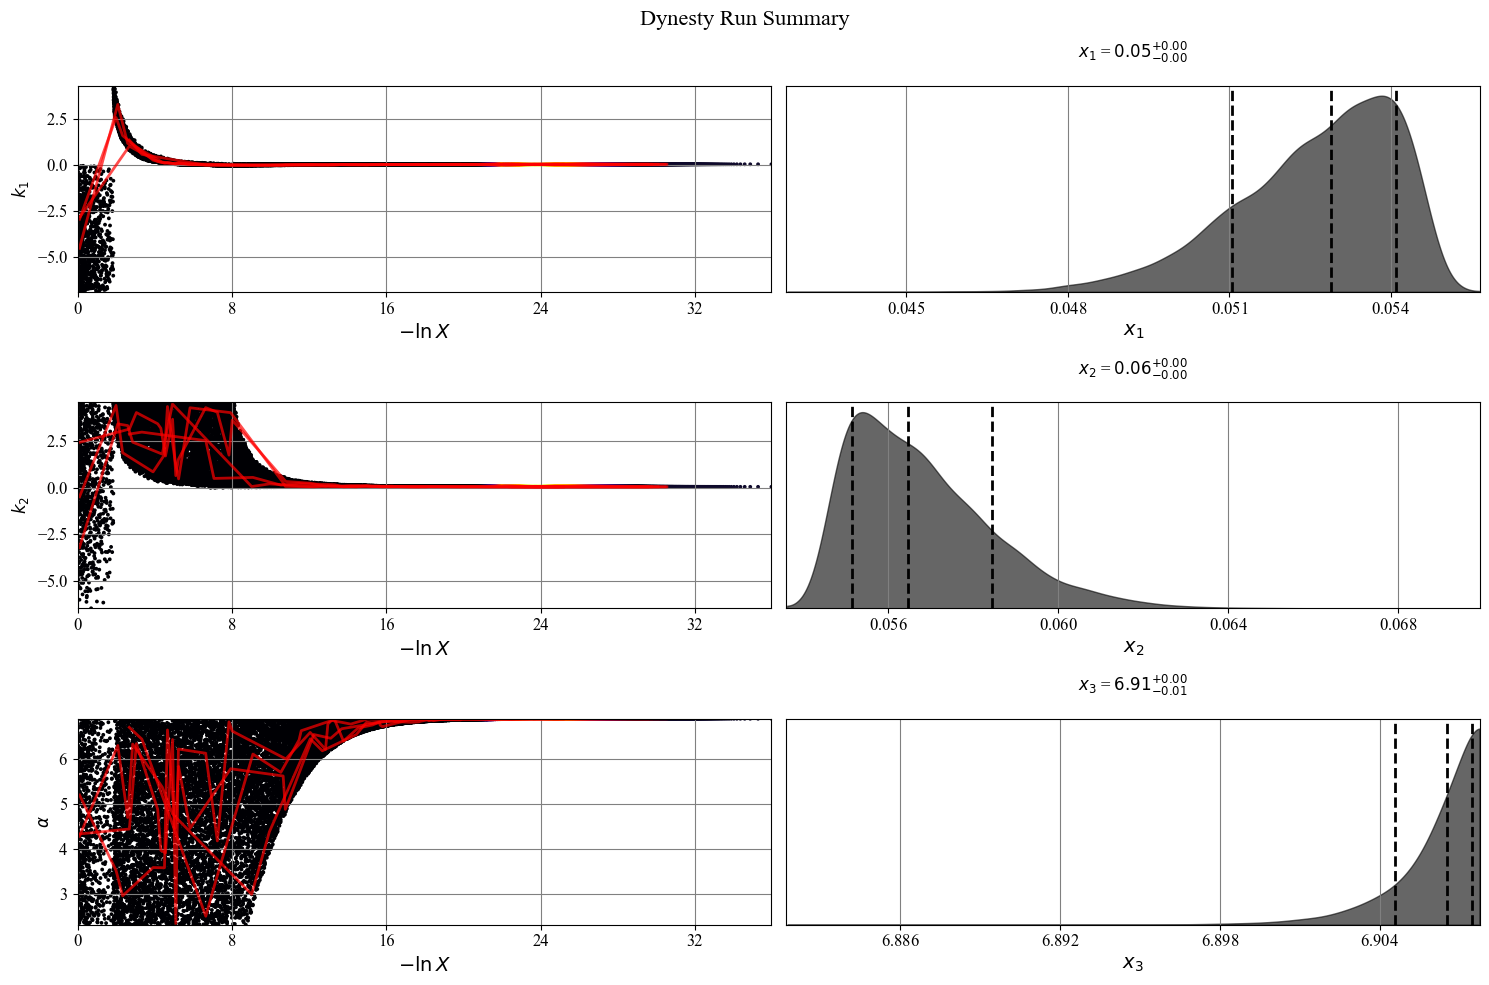

In [20]:
tfig, taxes = dyplot.traceplot(sresults, quantiles=[0.16, 0.5, 0.84], post_color='black', connect=True,  use_math_text=True, show_titles=True, title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 14}, truth_color='red', kde=False, trace_cmap='inferno')

tfig.suptitle("Dynesty Run Summary", fontsize=16)
taxes[0, 0].set_ylabel(r"$k_1$", fontsize=12)
taxes[1, 0].set_ylabel(r"$k_2$", fontsize=12)
taxes[2, 0].set_ylabel(r"$\alpha$", fontsize=12)

tfig.set_size_inches(15, 10)
tfig.tight_layout()


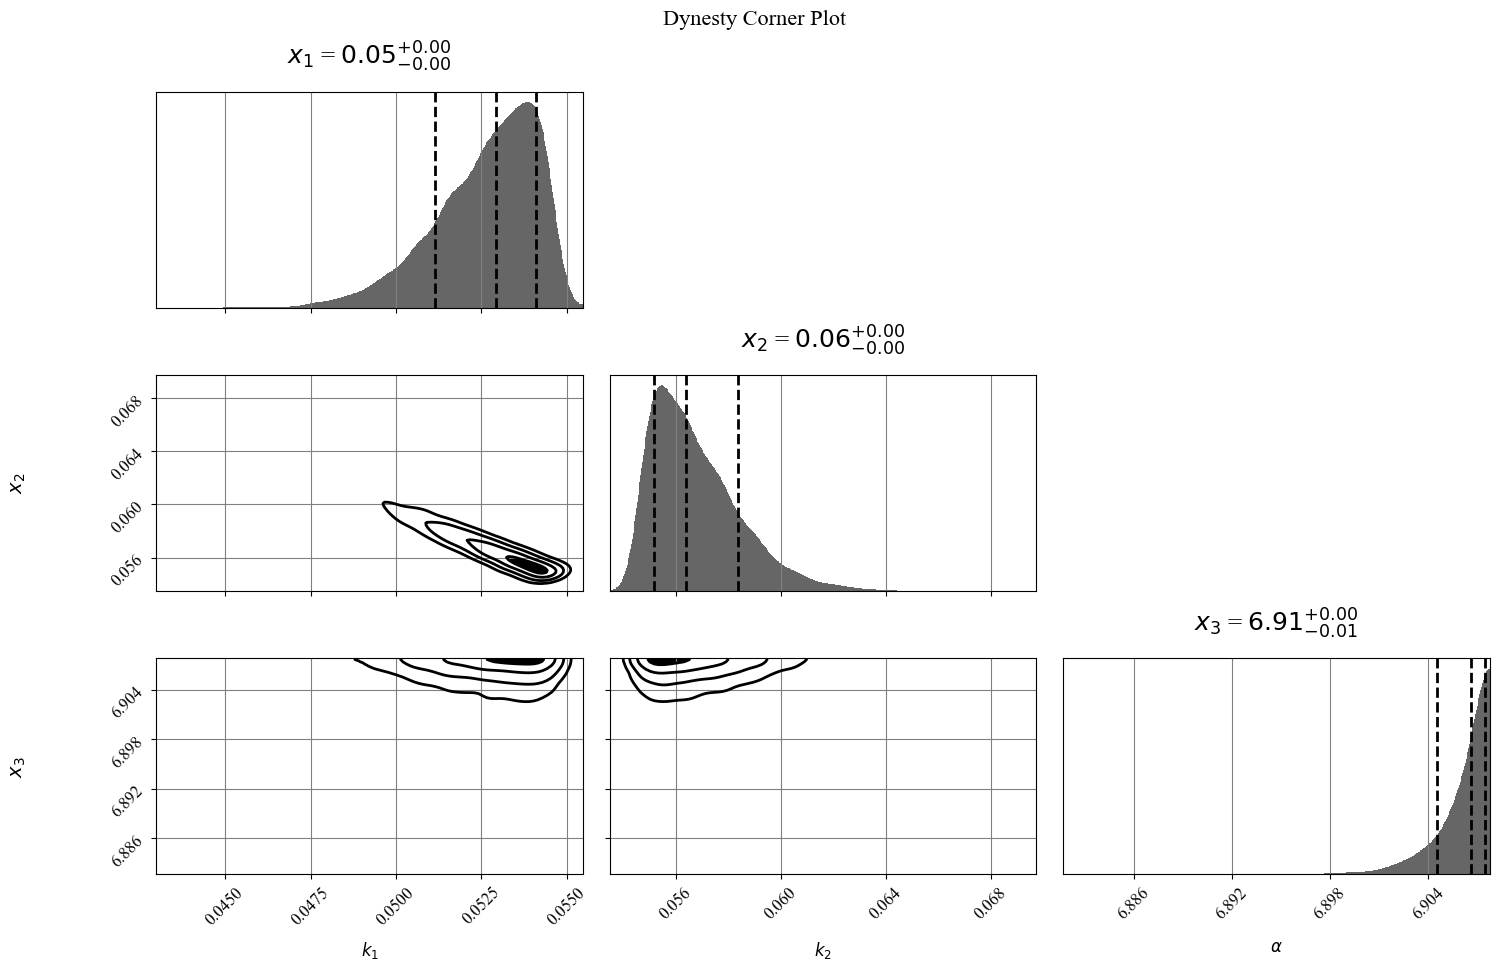

In [138]:
cfig, caxes = dyplot.cornerplot(sresults, color='black', quantiles=[0.16, 0.5, 0.84], show_titles=True)

caxes[2, 0].set_xlabel(r"$k_1$", fontsize=12)
caxes[2, 1].set_xlabel(r"$k_2$", fontsize=12)
caxes[2, 2].set_xlabel(r"$\alpha$", fontsize=12)
cfig.suptitle("Dynesty Corner Plot", fontsize=16)
cfig.set_size_inches(15, 10)
cfig.tight_layout()